# Parte 1: Árvore de Decisão

## Parâmetros editáveis

In [78]:
# Arquivo de dados
file_name = './accident_data.csv'
#file_name = './debug.csv'

# Tamanho do set de treino
training_ratio = 0.8

Antes de executar este caderno, pode ser necessário instalar previamente as dependências em seu sistema. Isso pode ser feito com os seguintes comandos:
```bash
pip install --user numpy
pip install --user pandas
pip install seaborn
```

## Dependencias


In [79]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix



## Importando os dados

In [80]:
# Import
dataset = pd.read_csv(file_name, sep = ",")

# Cleaning
# dataset = dataset[]

# Printing
dataset

,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee ou Terceiro,Risco Critico
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools
3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others
4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others
...,...,...,...,...,...,...,...,...,...
434,2017-07-04 00:00:00,Country_01,Local_04,Mining,I,III,Male,Third Party,Others
435,2017-07-04 00:00:00,Country_01,Local_03,Mining,I,II,Female,Employee,Others
436,2017-07-05 00:00:00,Country_02,Local_09,Metals,I,II,Male,Employee,Venomous Animals
437,2017-07-06 00:00:00,Country_02,Local_05,Metals,I,II,Male,Employee,Cut


## Pré-Processamento

In [81]:
def enumeracao(valores):
    mapping = {}
    translating = {}
    cont = 0
    for val in valores:
        if val not in mapping:
            mapping[val] = cont
            translating[cont] = val
            cont += 1
    return mapping, translating, cont

In [82]:
translators = {}
sizes = {}

for col in dataset.columns:
    mapping, translating, size = enumeracao(dataset[col])
    dataset[col] = dataset[col].map(mapping)
    
    translators[col] = translating
    sizes[col] = size

dataset

,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee ou Terceiro,Risco Critico
0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,1,1
2,2,0,2,0,0,1,0,2,2
3,3,0,3,0,0,2,0,0,3
4,4,0,3,0,1,0,0,0,3
...,...,...,...,...,...,...,...,...,...
434,283,0,3,0,0,1,0,0,3
435,283,0,2,0,0,3,1,1,3
436,284,1,9,1,0,3,0,1,21
437,285,1,4,1,0,3,0,1,13


## Separando em treino e teste

In [83]:
# Treino
#train = dataset.sample(frac=training_ratio, random_state=21)
train = dataset.sample(frac=training_ratio)
# Teste
test = dataset.drop(train.index)

## Estrutura de Dados

In [84]:
from abc import ABC

class DesisionTree(ABC):
    def inferencia(self, value):
        raise NotImplementedError()

class Node(DesisionTree):
    def __init__(self, test):
        self.test = test
        self.trees = np.empty((sizes[test],), dtype=object)
        self.num_trees = 0

    def add_tree(self, tree, idx):
        self.trees[idx] = tree
        self.num_trees += 1

    def inferencia(self, value):
        val = value[self.test]
        return self.trees[val].inferencia(value)

class Leaf(DesisionTree):
    def __init__(self, label):
        self.label = label

    def inferencia(self, value):
        return self.label

## Funções Auxiliares

In [85]:
class_name = 'Accident Level'
quant_classes = sizes[class_name]

def distribuicao(valores):
    dist = {}
    for val in valores:
        if val in dist:
            dist[val] += 1
        else:
            dist[val] = 1
    return dist

def valor_maioria(dist_valores):
    max_quant = -1 
    max_class = ''
    for item in dist_valores.items():
        if item[1] > max_quant:
            max_quant = item[1]
            max_class = item[0]
    return max_class

def calcula_entropia(exemplos):
    probabilities = np.zeros((quant_classes))

    total_number = len(exemplos)
    for ex in exemplos[class_name]:
        probabilities[ex] += 1
    
    old_settings = np.seterr(all='ignore')  # Disable warnings
    probabilities /= total_number
    
    entropy = (-probabilities) * (np.log2(probabilities))
    np.seterr(**old_settings) # Enable warnings back
    return np.nan_to_num(entropy).sum()

def melhor_atributo(atributos, exemplos):
    total_number = len(exemplos)
    entropia = calcula_entropia(exemplos)

    max_ganho = -np.inf
    max_atrib = ''
    for atrib in atributos:
        ganho = entropia
        for val in range(sizes[atrib]):
            filterring = exemplos[atrib] == val
            exemplos_com = exemplos[filterring]

            ganho -= (len(exemplos_com) / total_number) * calcula_entropia(exemplos_com)
        if ganho > max_ganho:
            max_ganho = ganho
            max_atrib = atrib
    return max_atrib

## Algoritmo de Treinamento

In [86]:
def treinamento(exemplos, atributos, padrao):
    if len(exemplos) == 0:
        return Leaf(padrao)

    dist = distribuicao(exemplos[class_name])
    if len(dist) == 1:
        return Leaf(list(dist.keys())[0])

    if len(atributos) == 0:
        return Leaf(valor_maioria(dist))
    
    melhor = melhor_atributo(atributos, exemplos)
    arvore = Node(melhor)
    maioria = valor_maioria(dist)

    for val in range(sizes[melhor]):
        filterring = exemplos[melhor] == val
        exemplos_i = exemplos[filterring]

        atributos_i = atributos.copy()
        atributos_i.discard(melhor)
        
        subarvore = treinamento(exemplos_i, atributos_i, maioria)
        arvore.add_tree(subarvore, val)
    return arvore

In [87]:
# Armazena o nome dos atributos em um conjunto
atributos = set()
for col in train.columns:
    atributos.add(col)

atributos.remove(class_name)

# Realiza o treinamento
solution = treinamento(train, atributos, '')

## Visualizando algumas respostas

In [88]:
# Visualizando algumas respostas
num_views = 5
for i in range(num_views):
    real = test.iloc[i][class_name]
    predicted = solution.inferencia(test.iloc[i])
    print('---------------------------')
    print('Real = ', translators[class_name][real], '| Predicted = ', translators[class_name][predicted])

---------------------------
Real =  I | Predicted =  I
---------------------------
Real =  IV | Predicted =  I
---------------------------
Real =  I | Predicted =  I
---------------------------
Real =  I | Predicted =  I
---------------------------
Real =  I | Predicted =  I


## Calculando a taxa de acerto no fração do dataset reservada para teste

In [89]:
count_acertos = 0
for i in range(len(test)):
    real = test.iloc[i][class_name]
    predicted = solution.inferencia(test.iloc[i])
    if real == predicted:
        count_acertos += 1

print('Porcentagem de acertos = ', count_acertos / len(test) * 100, '%')

Porcentagem de acertos =  72.72727272727273 %


## Matriz de confusão

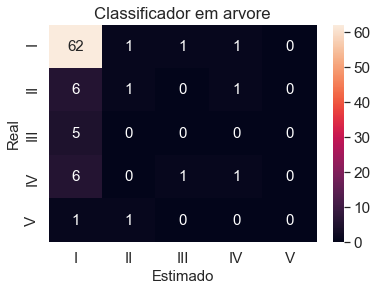

Estatistica Kappa:  0.1504424778761062


In [90]:
y_true = []
y_pred = []
for i in range(len(test)):
    y_true.append(test.iloc[i][class_name])
    y_pred.append(solution.inferencia(test.iloc[i]))

cm = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cm, ['I', 'II', 'III', 'IV', 'V'], ['I', 'II', 'III', 'IV', 'V'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}) # font size

plt.xlabel('Estimado', fontsize = 15)
plt.ylabel('Real', fontsize = 15)
plt.title('Classificador em arvore')
plt.show()
print("Estatistica Kappa: ", cohen_kappa_score(y_true, y_pred))

---
# Parte 2: Classificador à priori

## Classificador por Média

In [91]:
# Classificador utilizando a média
media = 0
for i in range(len(train)):
    media += train.iloc[i][class_name]
class_media = round(media / len(train))


In [92]:
# Visualizando algumas respostas
num_views = 5
for i in range(num_views):
    real = test.iloc[i][class_name]
    predicted = class_media
    print('---------------------------')
    print('Real = ', translators[class_name][real], '| Predicted = ', translators[class_name][predicted])

---------------------------
Real =  I | Predicted =  IV
---------------------------
Real =  IV | Predicted =  IV
---------------------------
Real =  I | Predicted =  IV
---------------------------
Real =  I | Predicted =  IV
---------------------------
Real =  I | Predicted =  IV


### Desempenho

In [93]:
count_acertos = 0
for i in range(len(test)):
    real = test.iloc[i][class_name]
    if real == class_media:
        count_acertos += 1

print('Porcentagem de acertos = ', count_acertos / len(test) * 100, '%')

Porcentagem de acertos =  9.090909090909092 %


### Matriz de confusao e Estatística Kappa

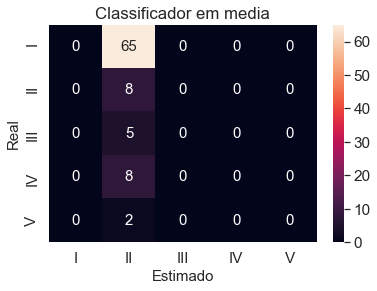

Estatistica Kappa:  0.0


In [94]:
y_true = []
y_pred = []
for i in range(len(test)):
    y_true.append(test.iloc[i][class_name])
    y_pred.append(class_media)

cm = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cm, ['I', 'II', 'III', 'IV', 'V'], ['I', 'II', 'III', 'IV', 'V'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}) # font size

plt.xlabel('Estimado', fontsize = 15)
plt.ylabel('Real', fontsize = 15)
plt.title('Classificador em media')
plt.show()
print("Estatistica Kappa: ", cohen_kappa_score(y_true, y_pred))

## Classificador por Moda

In [95]:
# Classificador utilizando a moda
moda = {}
for i in range(len(train)):
    if train.iloc[i][class_name] in moda:
        moda[train.iloc[i][class_name]] += 1
    else:
        moda[train.iloc[i][class_name]] = 1

value_moda = -1
class_moda = -1
for key in moda:
    if moda[key] > value_moda:
        value_moda = moda[key]
        class_moda = key

### Desempenho

In [96]:
count_acertos = 0
for i in range(len(test)):
    real = test.iloc[i][class_name]
    if real == class_moda:
        count_acertos += 1

print('Porcentagem de acertos = ', count_acertos / len(test) * 100, '%')

Porcentagem de acertos =  73.86363636363636 %


### Matriz de Confusão e Estatística Kappa

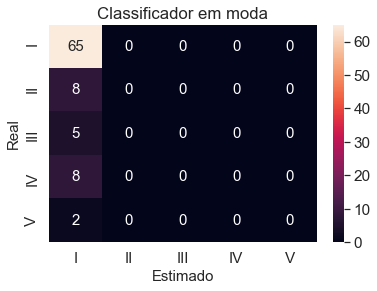

Estatistica Kappa:  0.0


In [97]:
y_true = []
y_pred = []
for i in range(len(test)):
    y_true.append(test.iloc[i][class_name])
    y_pred.append(class_moda)

cm = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cm, ['I', 'II', 'III', 'IV', 'V'], ['I', 'II', 'III', 'IV', 'V'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}) # font size

plt.xlabel('Estimado', fontsize = 15)
plt.ylabel('Real', fontsize = 15)
plt.title('Classificador em moda')
plt.show()
print("Estatistica Kappa: ", cohen_kappa_score(y_true, y_pred))

# Parte3: Refazendo a análise desconsiderando alguns dados

## Desconsiderando as datas e os países

In [98]:
dataset.drop('Countries', axis=1,inplace=True)
# dataset.drop('Employee ou Terceiro', axis=1,inplace=True)
dataset.drop('Data', axis=1,inplace=True)
dataset

,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee ou Terceiro,Risco Critico
0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,1
2,2,0,0,1,0,2,2
3,3,0,0,2,0,0,3
4,3,0,1,0,0,0,3
...,...,...,...,...,...,...,...
434,3,0,0,1,0,0,3
435,2,0,0,3,1,1,3
436,9,1,0,3,0,1,21
437,4,1,0,3,0,1,13


## Separa os dados de treino e de teste

In [99]:
# Treino
#train = dataset.sample(frac=training_ratio, random_state=21)
train = dataset.sample(frac=training_ratio)
# Teste
test = dataset.drop(train.index)

## Treinando

In [100]:
# Armazena o nome dos atributos em um conjunto
atributos = set()
for col in train.columns:
    atributos.add(col)

atributos.remove(class_name)

# Realiza o treinamento
solution = treinamento(train, atributos, '')

## Taxa de Acerto

In [101]:
count_acertos = 0
for i in range(len(test)):
    real = test.iloc[i][class_name]
    predicted = solution.inferencia(test.iloc[i])
    if real == predicted:
        count_acertos += 1

print('Porcentagem de acertos = ', count_acertos / len(test) * 100, '%')

Porcentagem de acertos =  72.72727272727273 %


## Matriz de Confusão e Estatística Kappa

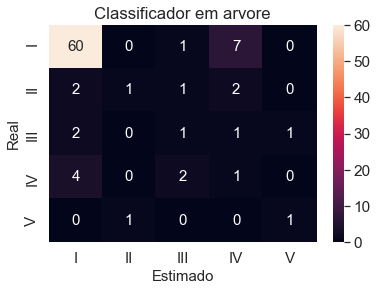

Estatistica Kappa:  0.29646902065289804


In [102]:
y_true = []
y_pred = []
for i in range(len(test)):
    y_true.append(test.iloc[i][class_name])
    y_pred.append(solution.inferencia(test.iloc[i]))

cm = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cm, ['I', 'II', 'III', 'IV', 'V'], ['I', 'II', 'III', 'IV', 'V'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}) # font size

plt.xlabel('Estimado', fontsize = 15)
plt.ylabel('Real', fontsize = 15)
plt.title('Classificador em arvore')
plt.show()
print("Estatistica Kappa: ", cohen_kappa_score(y_true, y_pred))